# Comparing sonification with pyo and thinkdsp

Based on test driving a bunch of different package options for sonification these were the top two options.

**Pyo** (http://ajaxsoundstudio.com/software/pyo/)
- Pluses
    - Fast input/ouput
    - Can create sound stream, stop at any time
    - Deals well with lots of point (weas successful using it for 
    - Decoupled output to sound file vs play in browser
    - 100% controllable by code commands
    - Playback starts immediately
- Minuses
    - Start/stop server architecture
    - Seems to kill kernal occasionally (due to server stuff)
    - Not the same sofware used my harvard sonification team 
    - Documentation is not the greatest
    - Building sound streams can be complicated
    - Play vs write, seperate operations
   
**ThinkDSP** (https://github.com/AllenDowney/ThinkX)
- Pluses
    - Easy to build sound stream
    - Same software used by harvard sonification team
    - Playback and file writing done on the same object
- Minuses
    - Makes gui to allow playback in browser 
    - Documentation is just a book, significantly lacking in detail
    - Time to build sound stream is up front, must completely finish before playback or writing out
- Question marks
    - Input/output time, currently slower than pyo, possibly could be mitigated by more efficient programming
   
### Contents   
1. [Imports](#Imports)
2. [Data](#Data)
3. [Flux to Pitch](#Flux-to-Pitch)
4. [Pyo](#Pyo)
5. [ThinkDSP](#Think-DSP)

## Imports

To install Pyo: `pip install -U pyo`

To install thinkdsp: `pip install thinkx`

In [6]:
import time

import numpy as np

import lightkurve

from astropy.io import fits
from astropy.visualization import (SqrtStretch, LogStretch, AsinhStretch, SinhStretch, LinearStretch,
                                   MinMaxInterval, ManualInterval, AsymmetricPercentileInterval)

import matplotlib
#%matplotlib inline
%matplotlib notebook

import matplotlib.pyplot as plt

import pyo
import thinkdsp
import simpleaudio

## Data

We'll get a couple of different light curves to try this on (all Kepler long cadence)

In [2]:
def get_light_curve(kid,quarter,cadence="long"):
    return  lightkurve.search_lightcurvefile(f"KIC {kid}", cadence=cadence, quarter=quarter).download_all()[0].SAP_FLUX.to_table()

In [3]:
def plot_lc(lc_table):
    """
    Plot a light curve.
    
    Expects column names 'time' and 'flux'.
    """
    
    f, ax = plt.subplots(figsize=(8, 4))
    ax.plot(lc_table['time'].jd, lc_table['flux'])
    ax.set_xlabel("Time (JD)")
    ax.set_ylabel("Flux")
        
    plt.show()

In [4]:
kid9775887_lc = get_light_curve(9775887, 6) # fast rotator with flares
kep12b_lc = get_light_curve(11804465, 1) # nice planet

In [5]:
kid9775887_lc = kid9775887_lc[~kid9775887_lc["flux"].mask]
kep12b_lc = kep12b_lc[~kep12b_lc["flux"].mask]

<IPython.core.display.Javascript object>


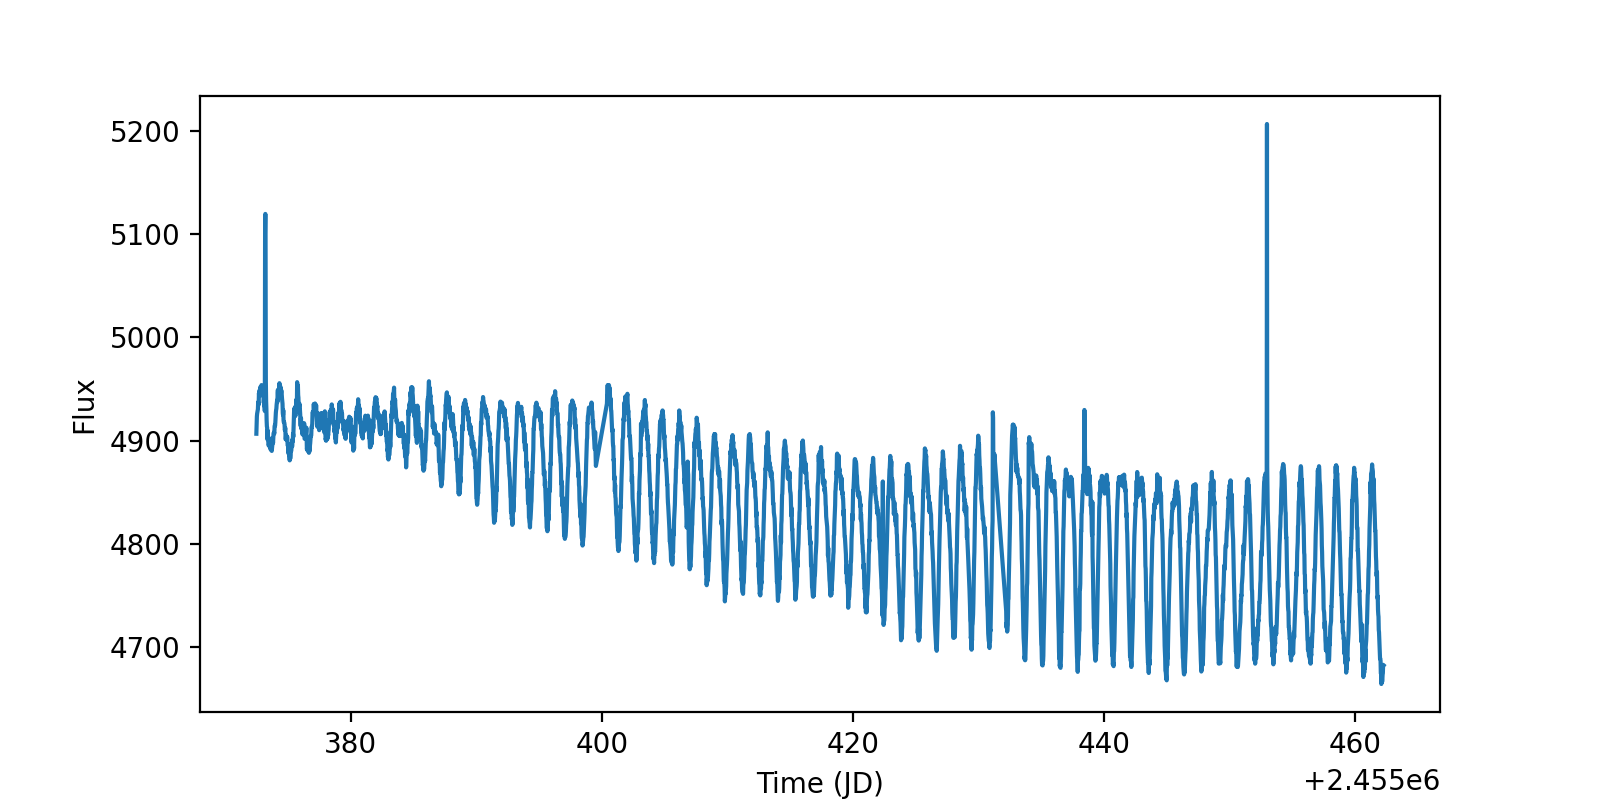

In [6]:
plot_lc(kid9775887_lc)

<IPython.core.display.Javascript object>


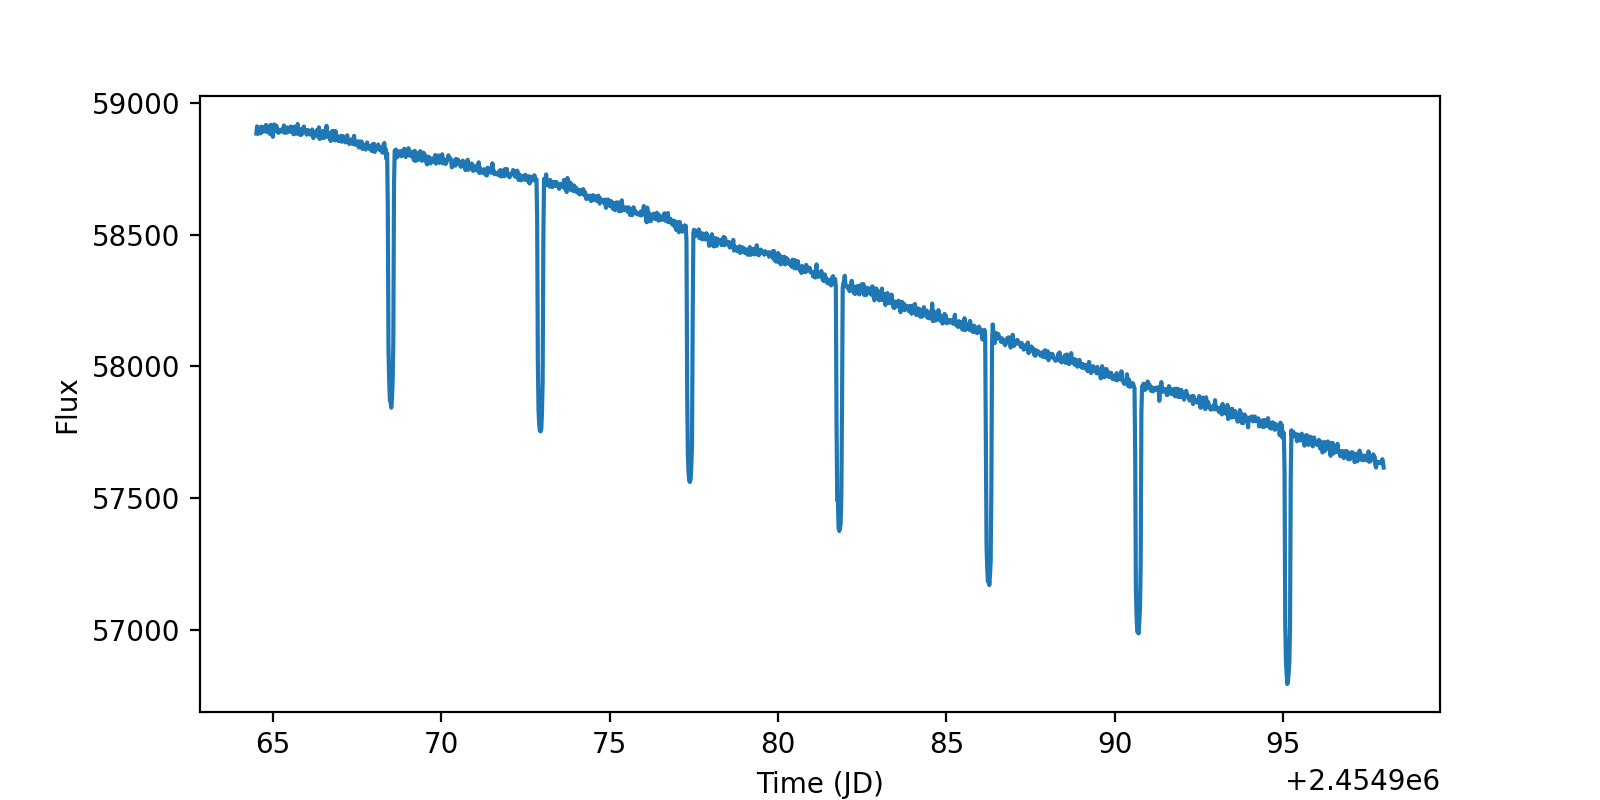

In [7]:
plot_lc(kep12b_lc)

## Flux to Pitch

We will use this function to transform flux values to audible pitches (in Hz).
This function is a prototype and will require refinement.

In [8]:
def data_to_pitch(data_array, pitch_range=[100,10000], center_value=440, stretch='linear', minmax_percent=None, minmax_value=None):
    """
    Map data array to audible pitches
    Apply given stretch and scaling to a data array, 

    Parameters
    ----------
    pitch_range : array
        Optional. Range of acceptable pitches in Hz. Defaults to commonly stated range of human
        hearing which is 20Hz-20kHz.
    data_array : array
        The input data array.
    stretch : str
        Optional, default 'asinh'. The stretch to apply to the image array.
        Valid values are: asinh, sinh, sqrt, log, linear
    minmax_percent : array
        Optional. Interval based on a keeping a specified fraction of pixels (can be asymmetric) 
        when scaling the image. The format is [lower percentile, upper percentile], where pixel
        values below the lower percentile and above the upper percentile are clipped.
        Only one of minmax_percent and minmax_value shoul be specified.
    minmax_value : array
        Optional. Interval based on user-specified pixel values when scaling the image.
        The format is [min value, max value], where pixel values below the min value and above
        the max value are clipped.
        Only one of minmax_percent and minmax_value should be specified.

    Returns
    -------
    response : array
        The normalized data array, with values in given pitch range.
    """

    # Check for a valid stretch
    if not stretch.lower() in ('asinh', 'sinh', 'sqrt', 'log', 'linear'):
        raise InvalidInputError("Stretch {} is not supported!".format(stretch))

    # Check the scaling
    if (minmax_percent is not None) and (minmax_value is not None):
        warnings.warn("Both minmax_percent and minmax_value are set, minmax_value will be ignored.",
                      InputWarning)

    # Setting up the transform with the scaling
    if minmax_percent:
        transform = AsymmetricPercentileInterval(*minmax_percent)
    elif minmax_value:
        transform = ManualInterval(*minmax_value)
    else:  # Default, scale the entire image range to [0,1]
        transform = MinMaxInterval()
        
    # Adding the stretch to the transform
    if stretch == 'asinh':
        transform += AsinhStretch()
    elif stretch == 'sinh':
        transform += SinhStretch()
    elif stretch == 'sqrt':
        transform += SqrtStretch()
    elif stretch == 'log':
        transform += LogStretch()

   
    # Performing the transform and then putting it into the pich range
    norm_img = transform(data_array)
    
    # Want the median to be in about the middle of the human hearing range
    med = np.median(norm_img)
    norm_img = np.multiply((center_value - pitch_range[0])/med, norm_img, out=norm_img) + pitch_range[0]
    
    
    #norm_img = np.multiply(pitch_range[1]-pitch_range[0], norm_img, out=norm_img) + pitch_range[0]
    
    return norm_img

In [9]:
kid9775887_lc["pitch"] = data_to_pitch(kid9775887_lc["flux"])
kep12b_lc["pitch"] = data_to_pitch(kep12b_lc["flux"])

/Users/cbrasseur/anaconda/envs/sonification/lib/python3.8/site-packages/numpy/core/fromnumeric.py:746: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Think DSP

Using the thinkdsp library for sonification examples.

### KIC 9775887 (fast rotating and flaring star)

#### Playing in browser

In [30]:
exptime = 0.01881188407271875 # LC cadence in days
duration = 0.5
spacing = 0.01
delays = [x for x in (kid9775887_lc["time"].jd - kid9775887_lc["time"].jd[0])/exptime*spacing]

In [31]:
st = time.time()

wave = None

for f,d in zip(list(kid9775887_lc["pitch"]),delays):
    if wave is None:
        wave = thinkdsp.sin_wave(f,duration,0)
        wave.apodize()
    else:
        w = thinkdsp.sin_wave(f,duration,0)
        w.apodize()
        wave += thinkdsp.rest(d) | w
        
print(f"{(time.time()-st):.2f} seconds.")

30.67 seconds.


In [33]:
wave.make_audio()

#### Saving to wav file

In [34]:
wave.write("kid9775887_long_thinkdsp.wav")

Writing ../data/kid9775887_long_thinkdsp.wav


/Users/cbrasseur/anaconda/envs/sonification/lib/python3.8/site-packages/thinkdsp.py:1115: UserWarning: Warning: normalizing before quantizing.
  warnings.warn('Warning: normalizing before quantizing.')


### Kepler 12b (exoplanet)

#### Playing in browser

In [35]:
exptime = 0.01881188407271875 # LC cadence in days
duration = 0.5
spacing = 0.01
delays = [x for x in (kep12b_lc["time"].jd - kep12b_lc["time"].jd[0])/exptime*spacing]

In [36]:
st = time.time()

wave = None

for f,d in zip(list(kep12b_lc["pitch"]),delays):
    if wave is None:
        wave = thinkdsp.sin_wave(f,duration,0)
        wave.apodize()
    else:
        w = thinkdsp.sin_wave(f,duration,0)
        w.apodize()
        wave += thinkdsp.rest(d) | w
        
print(f"{(time.time()-st):.2f} seconds.")

3.77 seconds.


In [164]:
wave.make_audio()

#### Saving to wav file

In [37]:
wave.write("kepler12b_long_thinkdsp.wav")

Writing ../data/kepler12b_long_thinkdsp.wav


## Pyo

Using the pyo library for sonification examples.

### KIC 9775887 (fast rotating and flaring star)

In [31]:
exptime = 0.01881188407271875 # LC cadence in days
duration = 0.5
spacing = 0.01
delays = [x for x in (kid9775887_lc["time"].jd - kid9775887_lc["time"].jd[0])/exptime*spacing for _ in (0,1)]
pitches = [x for x in kid9775887_lc["pitch"] for _ in (0,1)]

#### Saving to wav file

In [32]:
st = time.time()

server = pyo.Server(audio="offline").boot()
server.recordOptions(dur=delays[-1]+duration, filename="kid9775887_long_pyo.wav")

env = pyo.Linseg(list=[(0,0),(.1,1),(duration-.1,1),(duration-.05,0.5),(duration-.005,0)],
                mul=[.05 for i in range(len(pitches))]).play(delay=delays, dur=duration)

sine = pyo.Sine(list(pitches), 0, env).out(delay=delays, dur=duration)

server.start()

print(f"{(time.time()-st):.2f} seconds.")

Pyo message: Offline Server rendering file kid9775887_long_pyo.wav dur=48.249850
Pyo message: Offline Server rendering finished.
2.23 seconds.


In [33]:
server.shutdown()

#### Playing the result

In [34]:
wave_obj = simpleaudio.WaveObject.from_wave_file("kid9775887_long_pyo.wav")
play_obj = wave_obj.play()

In [35]:
play_obj.stop()

#### Playing in browser

**Note:** This does not work in mybinder!

In [11]:
server = pyo.Server().boot()
server.start()

Pyo warning: Portmidi warning: no midi device found!
Portmidi closed.


In [16]:
env = pyo.Linseg(list=[(0,0),(.01,1),(duration-.1,1),(duration-.05,0.5),(duration-.005,0)],
                mul=[.2 for i in range(len(pitches))]).play(delay=delays, dur=duration)

s = pyo.Sine(list(pitches), 0, env).out(delay=delays, dur=duration)

In [17]:
s.stop()

< Instance of Sine class >

In [18]:
server.shutdown()

### Kepler 12b (exoplanet)

In [17]:
exptime = 0.01881188407271875 # LC cadence in days
duration = 0.5
spacing = 0.01
delays = [x for x in (kep12b_lc["time"].jd - kep12b_lc["time"].jd[0])/exptime*spacing for _ in (0,1)]

#### Saving to wav file

In [27]:
st = time.time()

server = pyo.Server(audio="offline").boot()
server.recordOptions(dur=delays[-1]+duration, filename="kepler12b_long_pyo.wav")

env = pyo.Linseg(list=[(0,0),(.1,1),(duration-.1,1),(duration-.05,0.5),(duration-.005,0)],
                mul=[.05 for i in range(len(kep12b_lc))]).play(delay=delays, dur=duration)

sine = pyo.Sine(list(kep12b_lc["pitch"]), 0, env).out(delay=delays, dur=duration)

server.start()

print(f"{(time.time()-st):.2f} seconds.")

Pyo message: Offline Server rendering file kepler12b_long_pyo.wav dur=18.292528
Pyo message: Offline Server rendering finished.
0.39 seconds.


In [28]:
server.shutdown()

#### Playing the result

In [29]:
wave_obj = simpleaudio.WaveObject.from_wave_file("kepler12b_long_pyo.wav")
play_obj = wave_obj.play()

In [30]:
play_obj.stop()

#### Playing in browser

**Note:** This does not work in mybinder!

In [22]:
server = pyo.Server().boot()
server.start()

Pyo warning: Portmidi warning: no midi device found!
Portmidi closed.


In [25]:
env = pyo.Linseg(list=[(0,0),(.01,1),(duration-.1,1),(duration-.05,0.5),(duration-.005,0)],
                mul=[.2 for i in range(len(kep12b_lc))]).play(delay=delays, dur=duration)

s = pyo.Sine(list(kep12b_lc["pitch"]), 0, env).out(delay=delays, dur=duration)

In [26]:
s.stop()

< Instance of Sine class >

In [27]:
server.shutdown()